In [7]:
import spacy
import pandas as pd
from numpy import random
import matplotlib.pyplot as plt
import re
import json
from tqdm import tqdm
import jsonlines
import seaborn as sns 

random.seed(0)

# adding special symbol to tokenizer
t

from spacy.tokenizer import Tokenizer
def custom_tokenizer(nlp):
    return Tokenizer(nlp.vocab, token_match=EOS_re.match)

nlp = spacy.load('en_core_web_sm')
nlp.tokenizer = custom_tokenizer(nlp)

From MNLI code, read data line by line. 

In [3]:
def load_nli_data(path):
    """
    Load MultiNLI or SNLI data.
    """
    LABEL_MAP = {
    "entailment": 0,
    "neutral": 1,
    "contradiction": 2}
    
    data = []
    with open(path) as f:
        for line in f:
            loaded_example = json.loads(line)
            if loaded_example["gold_label"] not in LABEL_MAP:
                continue
            loaded_example["label"] = LABEL_MAP[loaded_example["gold_label"]]
            data.append(loaded_example)
            
        random.seed(1)
        random.shuffle(data)
        
    return data

Read MNLI data as JSONL. Split data in 50-50 train-test (finetune-generate). 

In [4]:
data = load_nli_data('../data/MNLI/original/multinli_1_train.jsonl')

train = pd.DataFrame(data[0:round(len(data)/2)])
test = pd.DataFrame(data[round(len(data)/2)+1:])

# # output half of data to pre-train, half to generate over
# train.to_json('mnli_bart_train.jsonl', orient ='records', lines=True)
# test.to_json('mnli_bart_test.jsonl', orient ='records', lines=True)

# Replicate Bart Denoising Task for Entailment

Replicate the "mask-infill" training objective found in BART Denoising task. 
Identical masking to mask_fill objective. Mask hypothesis, then concate premise to masked hypothesis, separated by special token `</s>` used for sentence entailment fine-tuning. 

In [5]:
def mask_span(span):
    
    sent = nlp(span)
    # sample mask span length from poisson with lambda = 3, as in BART denoising paper
    draw = random.poisson(3)
    
    # if masked span is longer than sentence
    if len(sent) - draw <= 0:
        return '<mask>'
    
    start_ind = random.randint(len(sent) - draw)
    
    # insert <mask> 
    if draw == 0:
        return sent[:start_ind].text + ' <mask> ' + sent[start_ind:].text
    
    masked_sent = sent[:start_ind].text + ' <mask> ' + sent[start_ind + draw:].text
    
    return masked_sent

In [6]:
f
# # mask premise
# masked_pairs = []
# original_pairs = []
# for index, row in tqdm(train.iterrows(), total=train.shape[0]):
#     masked_prem = mask_span(row['sentence1'])
    
#     # appending masked and original premise + </s> + hypo pairs
#     masked_pairs.append(masked_prem + ' </s> ' + row['sentence2'])
#     original_pairs.append(row['sentence1'] + ' </s> ' + row['sentence2'])

# pickle.dump(masked_pairs, open("prem_denoised_input.pkl", "wb"))
# pickle.dump(original_pairs, open("prem_denoised_output.pkl", "wb"))  

100%|██████████| 196351/196351 [14:47<00:00, 221.18it/s]


In [9]:
masked_pairs

['It is designed to give the utilities flexibility in determining how and where to achieve the reductions. </s> Utilities will have <mask> reduce rates.',
 'Many had hoped that the daughter of former President Sukarno, Megawati Sukarnoputri, would play the central role that Corazen Aquino did, but that has not happened. </s> Many hoped Megawari Sukarnoputri would play a <mask> central role.',
 'well i guess that covers it It was real good talking to you </s>  <mask> horrible talking to you.',
 "oh yeah they shouldn't leave anything in Bagdad taller than three feet </s>  <mask> anything short in Baghdad.",
 'Such a policy would displease many black politicians, since it stands to diminish black political representation in the short run. </s> The policy <mask> black politicians.',
 'For many, the best reason for visiting the basilica is the view of the city from the dome or the terrace below. </s> The basilica <mask> great view of the city.',
 'Here was an idea intellectuals might also e

Format the input-output of train-val-test splits for **fairseq** fine-tuning. 

In [8]:
import pickle
import numpy as np

ip = pickle.load(open("hypo_denoised_input.pkl", "rb"))
op = pickle.load(open("hypo_denoised_output.pkl", "rb"))

ip = np.asarray(ip)
op = np.asarray(op)
 
indices = np.arange(ip.shape[0])
np.random.shuffle(indices)

ip = ip[indices]
op = op[indices]
DIR = "./" #"../Bart/Denoised/"
pickle.dump(indices, open(DIR+"denoised_shuffle_indices.pkl", "wb"))

# 70-10-20 split

train_ind = round(len(ip)*0.7)
test_ind = round(len(ip)*0.8)

for i in range(len(ip)):
    ip[i] = ' '.join(ip[i].split())
    op[i] = ' '.join(op[i].split())

with open(DIR+"train.source", "w") as f1, open(DIR+"train.target", "w") as f2:
    for i in range(len(ip[:train_ind])):
        f1.write(ip[i].strip()+'\n')
        f2.write(op[i].strip()+'\n')

with open(DIR+"val.source", "w") as f1, open(DIR+"val.target", "w") as f2:
    for i in range(len(ip[train_ind:test_ind])):
        f1.write(ip[train_ind+i].strip()+'\n')
        f2.write(op[train_ind+i].strip()+'\n')

with open(DIR+"test.source", "w") as f1, open(DIR+"test.target", "w") as f2:
    for i in range(len(ip[test_ind:])):
        f1.write(ip[test_ind+i].strip()+'\n')
        f2.write(op[test_ind+i].strip()+'\n')

# Visualizing Poisson Lambda Draws

As in the original BART Denoising paper, for mask infilling the training task is to mask spans of length drawn from a Poisson distribution. The following graphs comparing the number of tokens in each hypothesis span and the draws from Poisson are meant to show that lambda = 3 is a decent setting, to avoid masking too much of the hypothesizes spans all the time.

In [15]:
lengths = [] 
for i in tqdm(range(len(train))):
    lengths.append(len(nlp(train['sentence1'][i])))

100%|██████████| 196351/196351 [28:21<00:00, 115.39it/s]


In [17]:
def draw_from_poisson(n, lbd):
    draws = []
    for i in range(n):
        draws.append(random.poisson(lbd))
    return draws

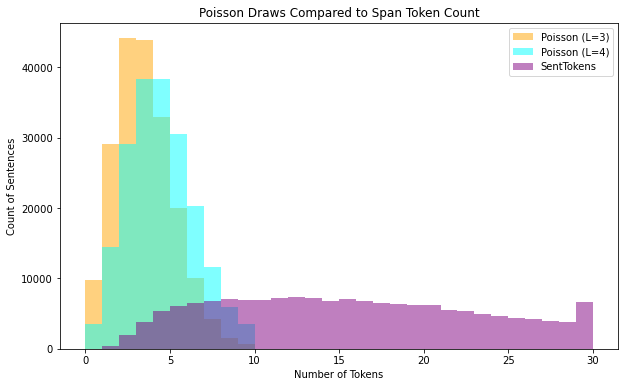

In [18]:
fig, ax = plt.subplots(figsize=(10,6))

# Poisson Draws
draws = draw_from_poisson(len(lengths), 3)
plt.hist(draws, 10, range = [0,10], alpha = 0.5, color = 'orange', align = 'mid', label = 'Poisson (L=3)')
draws = draw_from_poisson(len(lengths), 4)
plt.hist(draws, 10, range = [0,10], alpha = 0.5, color = 'cyan', align = 'mid', label = 'Poisson (L=4)')

# Number of Tokens in Sentence Span
plt.hist(lengths, 30, range= [0,30], alpha = 0.5, color = 'purple', label = 'SentTokens', align = 'mid')
plt.xlabel('Number of Tokens')
plt.ylabel('Count of Sentences')
plt.title('Poisson Draws Compared to Span Token Count')
plt.legend()

In [1]:
t = [0,1,2,3,4,5]

In [2]:
t[0:1]

[0]

In [3]:
t[1:2]

[1]